In [19]:
import os
import json
import keras
import numpy as np
from keras.preprocessing.text import Tokenizer
import math
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D,Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding,Dropout,LSTM
from keras.models import Model, Sequential
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import regularizers
import matplotlib.pyplot as plt

In [20]:
file_list = os.listdir('data')
text=[]
sentiment=[]
for file in file_list:
    with open('data/'+file,'r') as f:
        d = json.load(f)
        text.extend(d['text'].values())
        sentiment.extend(d['sentiment'].values())
X=text
Y=sentiment

In [21]:
X=[]
Y=[]
for i in range(len(sentiment)):
    if sentiment[i]!='neutral':
        X.append(text[i])
        Y.append(1 if sentiment[i]=='positive' else 0)

In [22]:
train_x=[]
train_y=[]#mark 1 as positive 0 as negative

file_list = os.listdir('aclImdb/train/pos')
for file in file_list:
    with open('aclImdb/train/pos/'+file,'rb') as f:
        s = f.read().decode('utf8')
        train_x.append(s)
pos_num=len(train_x)
train_y.extend([1]*pos_num)

file_list = os.listdir('aclImdb/train/neg')
for file in file_list:
    with open('aclImdb/train/neg/'+file,'rb') as f:
        s = f.read().decode('utf8')
        train_x.append(s)
neg_num=len(train_x)-pos_num
train_y.extend([0]*neg_num)
        

In [23]:
'''This script loads pre-trained word embeddings (GloVe embeddings)
into a frozen Keras Embedding layer, and uses it to
train a text classification model on the 20 Newsgroup dataset
(classification of newsgroup messages into 20 different categories).
GloVe embedding data can be found at:
http://nlp.stanford.edu/data/glove.6B.zip
(source page: http://nlp.stanford.edu/projects/glove/)
'''

BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
TEXT_DATA_DIR = os.path.join(BASE_DIR, '20_newsgroup')
MAX_SEQUENCE_LENGTH = 1611
MAX_NUM_WORDS = 4000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2


In [24]:
# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'),encoding='utf-8') as f:
    
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))


Indexing word vectors.
Found 400000 word vectors.


In [25]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train_x)



sequences = tokenizer.texts_to_sequences(train_x)
sequences_test = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 88582 unique tokens.


In [26]:
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

In [27]:
x_train.shape

(25000, 1611)

In [28]:
x_train[1]

array([  0,   0,   0, ...,   5, 335, 405])

In [29]:
#first column represent positive
def buildy(i):
    return [1,0] if i==1 else [0,1]
y_train=[buildy(y) for y in train_y]
y_test=[buildy(y) for y in Y]
y_train=np.asarray(y_train)
y_test=np.asarray(y_test)

In [30]:
y_train.shape

(25000, 2)

In [31]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [32]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [33]:
rglrzr = regularizers.l2(0.001)

In [34]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(17,recurrent_regularizer=rglrzr))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1611, 100)         400100    
_________________________________________________________________
lstm_4 (LSTM)                (None, 17)                8024      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 36        
Total params: 408,160
Trainable params: 8,060
Non-trainable params: 400,100
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 256s 13ms/step - loss: 0.6060 - acc: 0.6780 - val_loss: 0.5153 - val_acc: 0.8390
Epoch 2/10
20000/20000 [==============================] - 257s 13ms/step - loss: 0.5107 - acc: 0.7633 - val_loss: 0.5515 - val_acc: 0.7578
Epoch 3/10
20000/20000 [==============================] - 254s 13ms/s

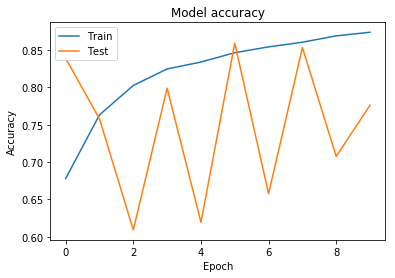

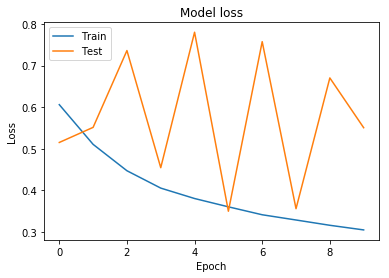

In [35]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [36]:
y_pred = model.predict(x_test)
def maxpos(li):
    if li[0]>li[1]  :
        return 0
    return 1
y_pre=[maxpos(y) for y in y_pred]
y_tes=[maxpos(y) for y in y_test]

In [37]:
confusion_matrix(y_true=y_tes,y_pred=y_pre,labels=[0,1])

array([[307,  10],
       [ 56,   6]], dtype=int64)